In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
%pylab inline
from scipy.stats import ttest_ind, ttest_ind_from_stats, ks_2samp
from scipy.special import stdtr
import seaborn as sns
sns.set_style("whitegrid")

np.random.seed(2017)

Populating the interactive namespace from numpy and matplotlib


In [2]:
delay = pd.read_csv('delay_95.csv')

In [6]:
taxi = pd.read_csv('finaldf.csv', index_col=0)

In [10]:
taxi['keycol'] = taxi.apply(lambda x: str(x.Station)+'_'+str(x.Date)+'_'+str(x.Hour), axis=1)

In [12]:
taxi = taxi.drop(['Station','Date','Hour'], axis=1)

In [13]:
taxi.head()

,Taxi_Rides,keycol
0,24,146_12_10
1,5,346_12_10
2,2,394_12_10
3,1,135_12_10
4,2,237_12_10


In [14]:
merged = pd.merge(delay, taxi, how='left', on='keycol')

In [17]:
merged.head()

,keycol,delay,Taxi_Rides
0,0_1_7,0,NaN
1,1_1_7,1,22.0
2,10_1_7,1,1.0
3,101_1_7,0,NaN
4,103_1_7,1,6.0


In [19]:
merged = merged.dropna()

In [7]:
# open from file
merged = pd.read_csv("merged_4_30.csv")
merged = merged.dropna()

In [8]:
merged['station'] = merged['keycol'].apply(lambda x: x.split('_')[0])
merged['hour'] = merged['keycol'].apply(lambda x: int(x.split('_')[2]))
merged.head()

,keycol,delay,Taxi_Rides,station,hour
0,1_1_7,1,27,1,7
1,2_1_7,0,16,2,7
2,3_1_7,1,16,3,7
3,5_1_7,3,4,5,7
4,6_1_7,2,35,6,7


In [9]:
the_delays = merged[merged.delay>0]
the_control = merged[merged.delay==0]
print "number of delays: " + str(len(the_delays))
print "number of good service (kind of): " + str(len(the_control))


number of delays: 11902
number of good service (kind of): 19338


In [10]:
print "mean taxi rides on delays: " + str(the_delays.Taxi_Rides.mean())
print "mean taxi rides on good services: " + str(the_control.Taxi_Rides.mean())

mean taxi rides on delays: 22.51159469
mean taxi rides on good services: 22.3908366946


In [11]:
t, p = ttest_ind(the_delays.Taxi_Rides, the_control.Taxi_Rides, equal_var=False)
print("ttest_ind:            t = %g  p = %g" % (t, p))

ttest_ind:            t = 0.3297  p = 0.741629


# by hour

In [12]:
by_hour = pd.DataFrame({'delay': the_delays.groupby('hour').mean()['Taxi_Rides'],
                        'control': the_control.groupby('hour').mean()['Taxi_Rides']})

In [13]:
by_hour.T

hour,7,8,9,10,11,12,13,14,15,16,17,18,19,20
control,20.172015,20.273458,21.162069,21.226255,21.419124,21.689525,23.239721,22.998694,21.691816,19.628079,23.774588,27.165791,26.095930,21.703704
delay,11.933439,17.340879,18.942428,20.726962,23.372487,24.462653,21.755332,23.567185,23.342400,20.525813,21.433993,27.806507,28.982979,24.435978


In [14]:
# let's test the p-value by hour
ks_p_values = []
ttest_p_values = []
for i in range(7,21):
    delay_per_hour = the_delays[the_delays.hour == i]['Taxi_Rides']
    control_per_hour = the_control[the_control.hour == i]['Taxi_Rides']
    t, pt = ttest_ind(control_per_hour,delay_per_hour, equal_var=False)
    k,pk = ks_2samp(control_per_hour, delay_per_hour)
    ks_p_values.append(pk)
    ttest_p_values.append(pt)

In [15]:
by_hour['ks p-values'] = ks_p_values
by_hour['t-test p-values'] = ttest_p_values
by_hour['significant'] = by_hour['t-test p-values'].apply(lambda x: 1 if x<0.05 else 0)
by_hour

,control,delay,ks p-values,t-test p-values,significant
hour,,,,,
7,20.172015,11.933439,5.099038e-14,8.440866e-07,1
8,20.273458,17.340879,1.201703e-05,4.502892e-02,1
9,21.162069,18.942428,6.110832e-01,7.686570e-02,0
10,21.226255,20.726962,1.241140e-01,7.081957e-01,0
11,21.419124,23.372487,1.310540e-01,1.489489e-01,0
12,21.689525,24.462653,2.071363e-04,3.239761e-02,1
13,23.239721,21.755332,4.189755e-01,2.229486e-01,0
14,22.998694,23.567185,9.552605e-01,6.722554e-01,0
15,21.691816,23.342400,5.065821e-01,2.405314e-01,0


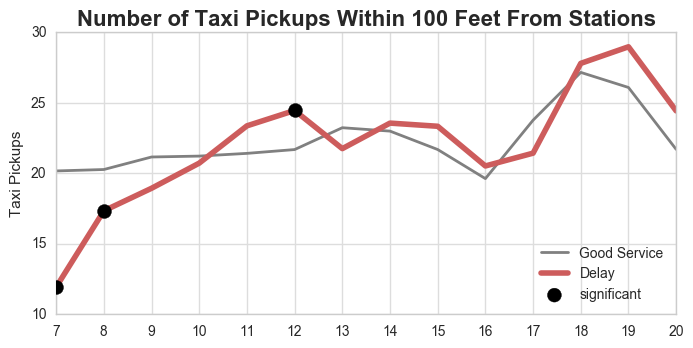

In [16]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(211)
plt.xticks(by_hour.index)
ax.scatter(by_hour[by_hour.significant==1].index,
           by_hour[by_hour.significant==1].delay,
          c="black",s=100, zorder=10, label='significant')
by_hour.control.plot(ax=ax, label="Good Service", c='gray', linewidth=2)
by_hour.delay.plot(ax=ax, label="Delay", c='IndianRed', linewidth=4)
ax.set_ylabel("Taxi Pickups")
ax.set_xlabel("")
plt.legend(loc='lower right')
ax.grid(color='#dddddd')
ax.set_title("Number of Taxi Pickups Within 100 Feet From Stations", fontweight='bold', fontsize=16)

# ax = fig.add_subplot(212)
# ax.set_xticks(by_hour.index)
# by_hour.p_values.plot(ax=ax, c='gray', linewidth=2)
# ax.set_title("p-values",fontweight="bold")
# ax.grid(color='#dddddd')



# by station

In [17]:
by_station = pd.DataFrame({'delay': the_delays.groupby('station').mean()['Taxi_Rides'],
                        'control': the_control.groupby('station').mean()['Taxi_Rides']})
by_station.dropna(inplace=True)

In [18]:
# let's test the p-value by station
ks_p_values = []
ttest_p_values = []
for i in by_station.index:
    delay_per_station = the_delays[the_delays.station == i]['Taxi_Rides']
    control_per_station = the_control[the_control.station == i]['Taxi_Rides']
    t, pt = ttest_ind(control_per_station,delay_per_station, equal_var=False)
    k,pk = ks_2samp(control_per_station, delay_per_station)
    ks_p_values.append(pk)
    ttest_p_values.append(pt)

C:\Users\Nurvirta\Anaconda2\lib\site-packages\scipy\stats\stats.py:3658: RuntimeWarning: invalid value encountered in absolute
  prob = distributions.t.sf(np.abs(t), df) * 2  # use np.abs to get upper tail
C:\Users\Nurvirta\Anaconda2\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Nurvirta\Anaconda2\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Nurvirta\Anaconda2\lib\site-packages\scipy\stats\_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
C:\Users\Nurvirta\Anaconda2\lib\site-packages\numpy\core\fromnumeric.py:3126: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\Nurvirta\Anaconda2\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in doubl

In [19]:
by_station['ks p-values'] = ks_p_values
by_station['t-test p-values'] = ttest_p_values
by_station['significant'] = by_station['t-test p-values'].apply(lambda x: 1 if x<0.05 else 0)
by_station.head()

,control,delay,ks p-values,t-test p-values,significant
0,14.405179,14.805882,0.373808,0.553975,0
1,34.878173,33.848780,0.307070,0.334102,0
10,1.393939,1.529412,0.999999,0.343809,0
103,1.000000,1.000000,1.000000,NaN,0
104,1.125000,1.090909,1.000000,0.828689,0


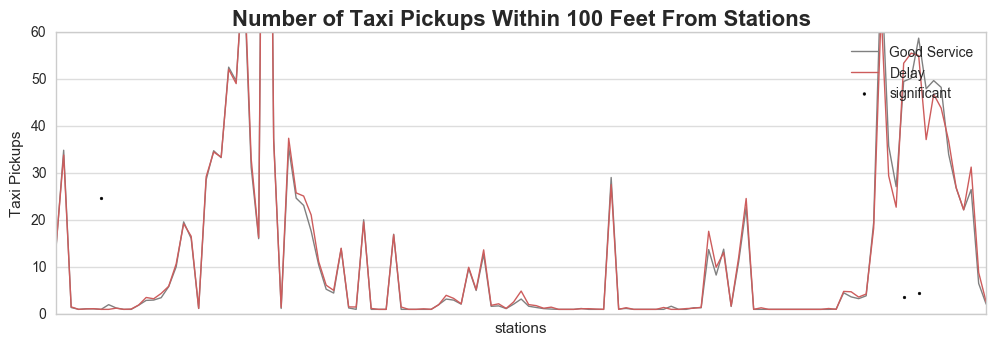

In [20]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(211)
plt.xticks(by_station.index)
ax.scatter(by_station[by_station.significant==1].index,
           by_station[by_station.significant==1].delay,
          c="black",s=4, zorder=20, label='significant')
by_station.control.plot(ax=ax, label="Good Service", c='gray', linewidth=1)
by_station.delay.plot(ax=ax, label="Delay", c='IndianRed', linewidth=1)
ax.set_ylabel("Taxi Pickups")
ax.set_xlabel("stations")
ax.set_ylim([0,60])
plt.legend(loc='upper right')
ax.grid(color='#dddddd')
ax.set_title("Number of Taxi Pickups Within 100 Feet From Stations", fontweight='bold', fontsize=16)

# ax = fig.add_subplot(212)
# ax.set_xticks(by_hour.index)
# by_hour.p_values.plot(ax=ax, c='gray', linewidth=2)
# ax.set_title("p-values",fontweight="bold")
# ax.grid(color='#dddddd')



In [34]:
significant_stations = by_station[by_station.significant==1].copy().reset_index()
significant_stations.rename(columns={'index':'id'}, inplace=True)
significant_stations['objectid'] = significant_stations['id'].apply(str)
significant_stations

,id,control,delay,ks p-values,t-test p-values,significant,objectid
0,113,2.909091,3.528090,5.642686e-01,2.448640e-02,1,113
1,115,3.483568,4.389535,4.712806e-02,3.669154e-03,1,115
2,132,23.126531,25.120690,9.688981e-02,4.212022e-02,1,132
3,133,17.651961,21.093023,2.745770e-02,1.961319e-03,1,133
4,135,5.287582,6.141732,8.235491e-02,1.678913e-02,1,135
5,221,1.000000,1.113636,9.939463e-01,2.354759e-02,1,221
6,225,3.192982,3.989130,4.575723e-02,4.509773e-03,1,225
7,234,2.113445,2.588235,2.420712e-01,2.137800e-02,1,234
8,235,3.198444,4.897727,6.262526e-03,2.387184e-04,1,235
9,236,1.664706,2.013889,5.856381e-02,2.900668e-02,1,236


In [35]:
subwayst = pd.read_csv("subway_station.csv")
subwayst.head()

,id,name,latitude,longitude,objectid
0,901,Grand Central - 42 St,40.752769,-73.979189,81.0
1,902,Times Sq - 42 St,40.755983,-73.986229,147.0
2,101,Van Cortlandt Park - 242 St,40.889248,-73.898583,271.0
3,103,238 St,40.884667,-73.900870,6.0
4,104,231 St,40.878856,-73.904834,267.0


In [36]:
subway = subwayst[['name','id']]


In [37]:
pd.merge(significant_stations, subway, how='left', on='id')

,id,control,delay,ks p-values,t-test p-values,significant,objectid,name
0,113,2.909091,3.528090,5.642686e-01,2.448640e-02,1,113,157 St
1,115,3.483568,4.389535,4.712806e-02,3.669154e-03,1,115,137 St - City College
2,132,23.126531,25.120690,9.688981e-02,4.212022e-02,1,132,14 St
3,133,17.651961,21.093023,2.745770e-02,1.961319e-03,1,133,Christopher St - Sheridan Sq
4,135,5.287582,6.141732,8.235491e-02,1.678913e-02,1,135,Canal St
5,221,1.000000,1.113636,9.939463e-01,2.354759e-02,1,221,3 Av - 149 St
6,225,3.192982,3.989130,4.575723e-02,4.509773e-03,1,225,125 St
7,234,2.113445,2.588235,2.420712e-01,2.137800e-02,1,234,Nevins St
8,235,3.198444,4.897727,6.262526e-03,2.387184e-04,1,235,Atlantic Av - Barclays Ctr
9,236,1.664706,2.013889,5.856381e-02,2.900668e-02,1,236,Bergen St
